<a href="https://colab.research.google.com/github/vachaconcu/Mineriadatos/blob/master/Retrato_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

Using TensorFlow backend.


In [0]:
tar = tarfile.open('/content/drive/My Drive/holi/photo.tar.gz')
tar.extractall()
tar = tarfile.open('/content/drive/My Drive/holi/sketch.tar.gz')
tar.extractall()

In [0]:
os.chdir('/content/photo')

nombres = os.listdir()
photo = []

for i in range(188):
  img = load_img(os.listdir()[i])
  img = img.crop((200,0,800,768))
  img_array = img_to_array(img)
  img_array = img_array/255
  photo.append(img_array)

os.chdir('/content/sketch')
photo2 = []

for i in range(188):
  if nombres[i]=="img(95).JPG":
    nombres[i]="img(95).jpg"
  if nombres[i]=="img(98).JPG":
    nombres[i]="img(98).jpg"
  if nombres[i]=="img(94).JPG":
    nombres[i]="img(94).jpg"
  if nombres[i]=="img(96).JPG":
    nombres[i]="img(96).jpg"
  if nombres[i]=="img(160).JPG":
    nombres[i]="img(160).jpg"
  if nombres[i]=="img(171).JPG":
    nombres[i]="img(171).jpg"
  img = load_img(nombres[i])
  img = img.resize((600,788))
  img = img.crop((0,20,600,788))
  img_array = img_to_array(img)
  img_array = img_array/255
  photo2.append(img_array)

photo = np.array(photo) 
photo2 = np.array(photo2)
print(photo.shape)
print(photo2.shape)

(188, 768, 600, 3)
(188, 768, 600, 3)


In [0]:
from sklearn.model_selection import train_test_split
photo,test=train_test_split(photo, test_size=0.2, random_state=42)
photo2,test2=train_test_split(photo2, test_size=0.2, random_state=42)

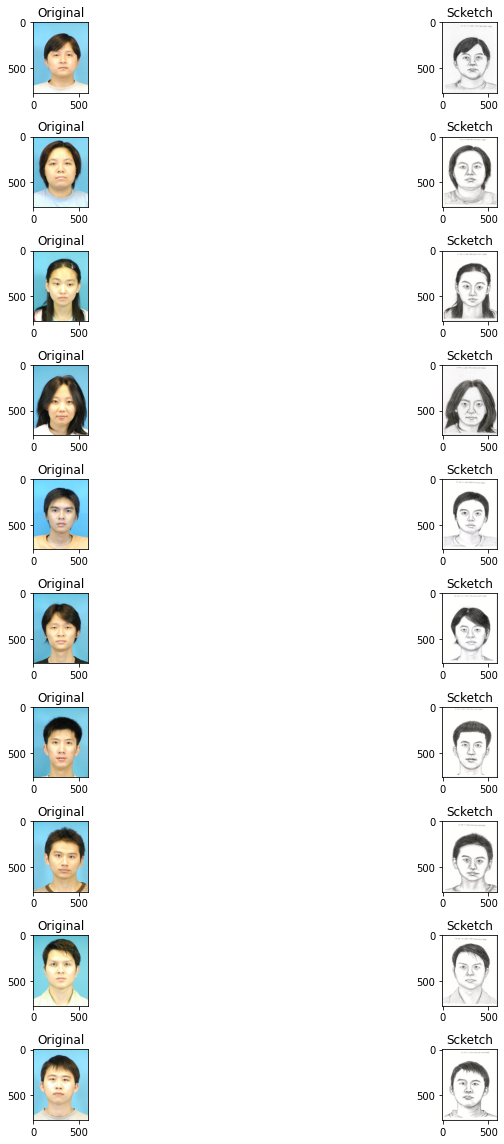

In [0]:
os.chdir('/content/drive/My Drive/Mineria/Retrato')
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray

fig, axes = plt.subplots(10, 2, figsize=(16,16))
ax = axes.ravel()
r=0
for i in range(80,90):
  ax[r].imshow(photo[i])
  ax[r].set_title("Original")
  ax[r+1].imshow(photo2[i])
  ax[r+1].set_title("Scketch")
  r=r+2

fig.tight_layout()
plt.show()

In [0]:
input_shape = photo[1].shape
kernel_size = 3
latent_dim = 20

(None, 384, 300, 32)
(None, 192, 150, 64)
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 768, 600, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 384, 300, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 150, 64)      18496     
_________________________________________________________________
flatten (Flatten)            (None, 1843200)           0         
_________________________________________________________________
latent_vector (Dense)        (None, 20)                36864020  
Total params: 36,883,412
Trainable params: 36,883,412
Non-trainable params: 0
_________________________________________________________________


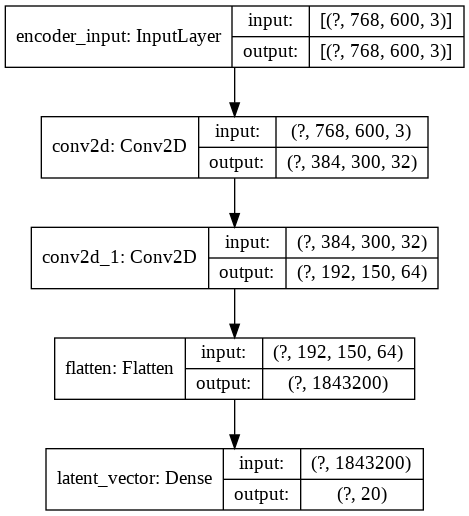

In [0]:
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    shape = K.int_shape(x)
    print(shape)
    
shape = K.int_shape(x)    
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)

In [0]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [0]:
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

In [0]:
x.shape

TensorShape([None, 768, 600, 32])

In [0]:
# reconstruct the input
outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 20)]              0         
_________________________________________________________________
dense (Dense)                (None, 1843200)           38707200  
_________________________________________________________________
reshape (Reshape)            (None, 192, 150, 64)      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 384, 300, 64)      36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 768, 600, 32)      18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 768, 600, 3)       867       
Total params: 38,763,459
Trainable params: 38,763,459
Non-trainable params: 0
_______________________________________________

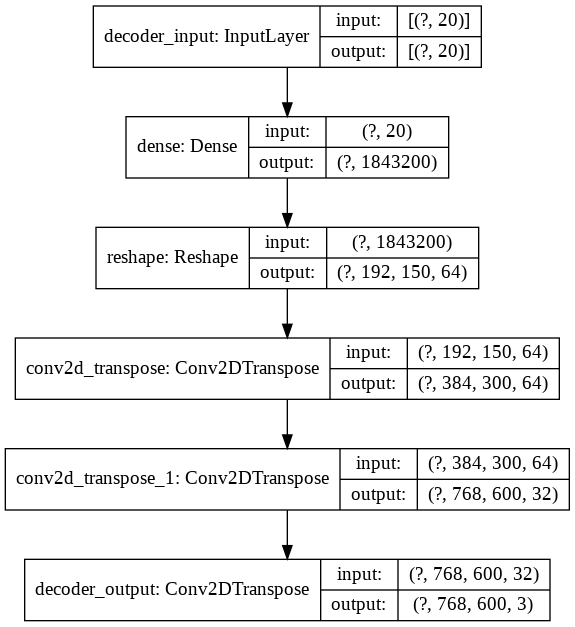

In [0]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 768, 600, 3)]     0         
_________________________________________________________________
encoder (Model)              (None, 20)                36883412  
_________________________________________________________________
decoder (Model)              (None, 768, 600, 3)       38763459  
Total params: 75,646,871
Trainable params: 75,646,871
Non-trainable params: 0
_________________________________________________________________


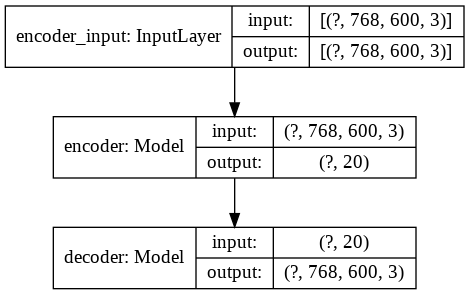

In [0]:
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()
plot_model(autoencoder,
           to_file='autoencoder.png',
           show_shapes=True)

In [0]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [0]:
import tensorflow as tf
import keras
os.chdir('/content/drive/My Drive/holi')
checkpoint_path = "training_1/cp_{epoch}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 save_weights_only=True,
                                                 save_best_only=True)

In [0]:
# train the autoencoder
history= autoencoder.fit(photo,photo2,validation_split=0.1,batch_size=16,callbacks=[cp_callback],epochs=300)

Epoch 1/300
9/9 [==============================] - 18s 2s/step - loss: 0.1176 - val_loss: 0.0538
Epoch 2/300
9/9 [==============================] - 14s 2s/step - loss: 0.0500 - val_loss: 0.0470
Epoch 3/300
9/9 [==============================] - 22s 2s/step - loss: 0.0465 - val_loss: 0.0458
Epoch 4/300
9/9 [==============================] - 21s 2s/step - loss: 0.0457 - val_loss: 0.0446
Epoch 5/300
9/9 [==============================] - 21s 2s/step - loss: 0.0449 - val_loss: 0.0436
Epoch 6/300
9/9 [==============================] - 21s 2s/step - loss: 0.0440 - val_loss: 0.0427
Epoch 7/300
9/9 [==============================] - 24s 3s/step - loss: 0.0429 - val_loss: 0.0408
Epoch 8/300
9/9 [==============================] - 22s 2s/step - loss: 0.0409 - val_loss: 0.0353
Epoch 9/300
9/9 [==============================] - 9s 954ms/step - loss: 0.0558 - val_loss: 0.0454
Epoch 10/300
9/9 [==============================] - 8s 923ms/step - loss: 0.0455 - val_loss: 0.0417
Epoch 11/300
9/9 [=======

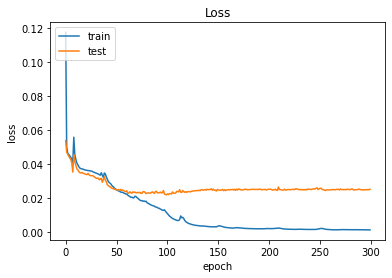

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
autoencoder.load_weights('/content/drive/My Drive/holi/training_1/cp_99.ckpt')

In [0]:
x_decoded = autoencoder.predict(test)

In [0]:
 autoencoder.evaluate(test,test2, verbose=2)

2/2 - 2s - loss: 0.0154


0.015362116508185863

In [0]:
test[1].shape

(768, 600, 3)

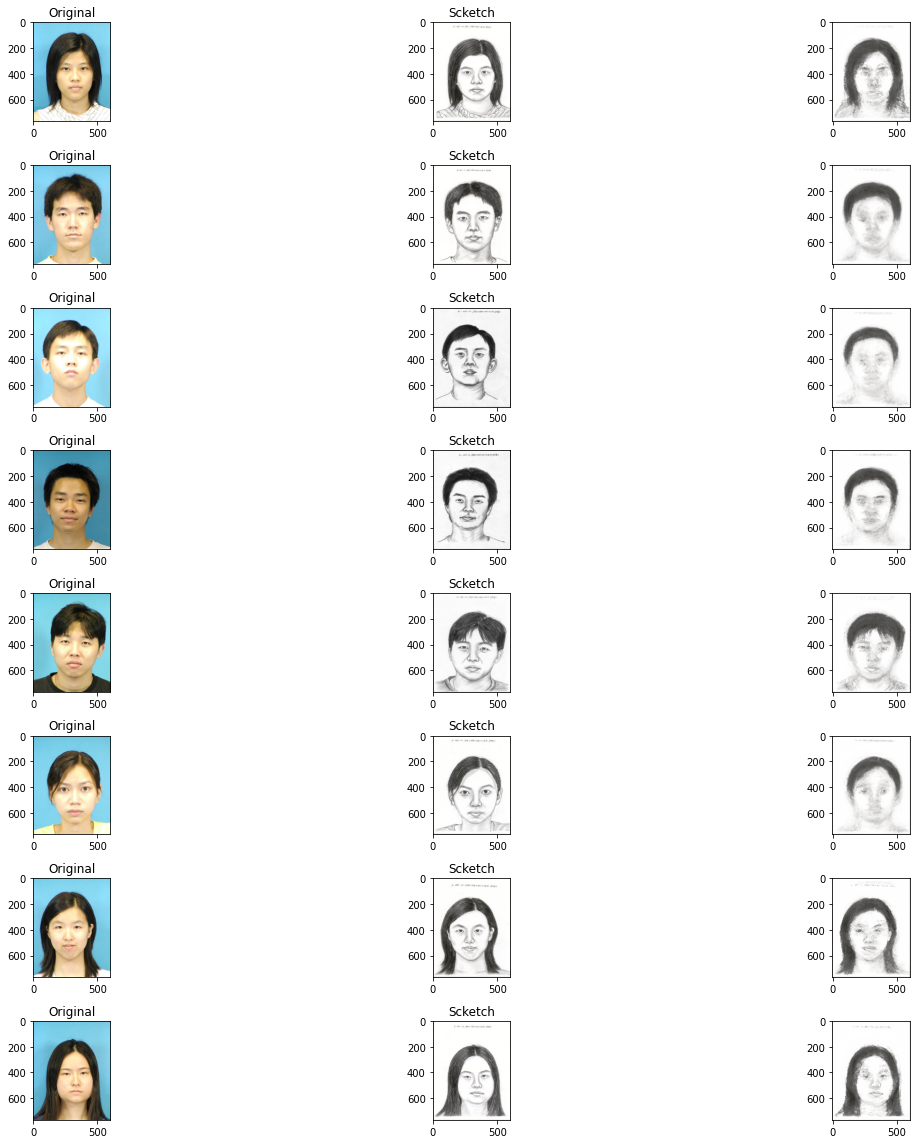

In [0]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray

fig, axes = plt.subplots(8, 3, figsize=(20,16))
ax = axes.ravel()
r=0
for i in range(30,38):
  ax[r].imshow(test[i])
  ax[r].set_title("Original")
  ax[r+1].imshow(test2[i])
  ax[r+1].set_title("Scketch")
  image = np.squeeze(x_decoded[i])
  ax[r+2].imshow(image)
  r=r+3

fig.tight_layout()
plt.show()

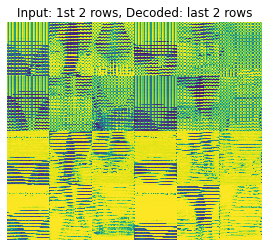

(8, 768, 600, 3)
(8, 768, 600, 3)


In [0]:
# display the 1st 8 test input and decoded images
imgs = np.concatenate([photo[:4], x_decoded[:4]])
imgs = imgs.reshape((4, -1, 768, 600))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none')
plt.savefig('input_and_decoded.png')
plt.show()
print(photo[:8].shape)
print(x_decoded[:8].shape)

In [0]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
autoencoder= load_model('/content/drive/My Drive/holi/modelo4.h5')